In [11]:
import random
import networkx as nx
import itertools
import time
import matplotlib.pyplot as plt
import os
import time

In [12]:
class Individual:
    def __init__(self, graph):
        self.graph = graph
        self.nodes = list(graph.nodes())
        self.code = [random.random() < 0.3 for _ in range(len(self.nodes))]  
        self.fitness = self.calc_fitness()  
    
    def is_independent_set(self):
        included_nodes = [node for idx, node in enumerate(self.nodes) if self.code[idx] == 1]
        
        for u, v in itertools.combinations(included_nodes, 2):
            if self.graph.has_edge(u, v):
                return False
        return True  
    
    def is_dominating_set(self):
        included_nodes = [node for idx, node in enumerate(self.nodes) if self.code[idx] == 1]
        dominating_nodes = set(included_nodes)
        
        for node in included_nodes:
            dominating_nodes.update(self.graph.neighbors(node))
        
        return len(dominating_nodes) == len(self.graph.nodes)
    
    def calc_fitness(self):
        included_nodes = [node for idx, node in enumerate(self.nodes) if self.code[idx] == 1]

        independent_penalty = 0
        for u, v in itertools.combinations(included_nodes, 2):
            if self.graph.has_edge(u, v):
                independent_penalty += 1

        dominating_nodes = set(included_nodes)
        for node in included_nodes:
            dominating_nodes.update(self.graph.neighbors(node))
        dominating_penalty = len(self.graph.nodes) - len(dominating_nodes)
        
        if independent_penalty == 0 and dominating_penalty == 0:
            return 1 / sum(self.code)  

        penalties = independent_penalty + dominating_penalty
        return -penalties

In [13]:
def selection(population, tournament_size):
    chosen = random.sample(population, tournament_size)
    return max(chosen, key=lambda individual: individual.fitness)

In [14]:
def crossover(parent1, parent2, child1, child2):
    random_pos = random.randrange(0, len(parent1.code))
    
    child1.code[:random_pos] = parent1.code[:random_pos]
    child1.code[random_pos:] = parent2.code[random_pos:]
    
    child2.code[:random_pos] = parent2.code[:random_pos]
    child2.code[random_pos:] = parent1.code[random_pos:]

In [15]:
def mutation(individual, mutation_prob):
    for i in range(len(individual.code)):
        if random.random() < mutation_prob:
            individual.code[i] = not individual.code[i]

In [16]:
def ga(population_size, num_generations, tournament_size, elitism_size, mutation_prob, graph):
    population = [Individual(graph) for _ in range(population_size)]
    new_population = population.copy()
    
    for _ in range(num_generations):
        population.sort(key=lambda x: x.fitness, reverse=True)
        new_population[:elitism_size] = population[:elitism_size]
        for j in range(elitism_size, population_size, 2):
            parent1 = selection(population, tournament_size)
            parent2 = selection(population, tournament_size)
            
            crossover(parent1, parent2, child1=new_population[j], child2=new_population[j+1])

            mutation(new_population[j], mutation_prob)
            mutation(new_population[j+1], mutation_prob)
            
            new_population[j].fitness = new_population[j].calc_fitness()
            new_population[j+1].fitness = new_population[j+1].calc_fitness()
        
        population = new_population.copy()
    return max(population, key=lambda x: x.fitness)

In [17]:
def ga_main(graph):
    best = ga(
        population_size=1000,
        num_generations=80,
        tournament_size=27,
        elitism_size=60,
        mutation_prob=0.05,
        graph=graph,
    )

    return best.code, best.fitness

In [18]:
def draw_graph(graph, min_set):
    pos = nx.spring_layout(graph)  
    plt.figure(figsize=(8, 6)) 
    
    nx.draw_networkx_edges(graph, pos, edge_color='gray', alpha=0.5)
    
    node_color = 'lightblue'
    node_color = ['red' if min_set[i] else 'lightblue' for i in range(len(graph.nodes))]
    
    nx.draw_networkx_nodes(graph, pos, node_color=node_color, node_size=500)
    
    nx.draw_networkx_labels(graph, pos)
    
    plt.title("Graf sa Minimalnim Nezavisnim Dominirajućim Skupom")
    plt.show()

Minimum Independent Dominating Set: [False, False, False, False, False, False, False, False, False, False, False, True, False, False, True, False, False, False, True, False]
Fitness (1 / length of the set): 0.3333333333333333


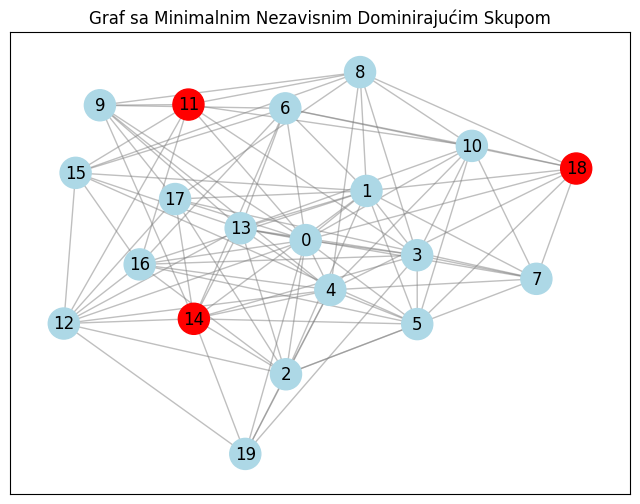

In [19]:
graph = nx.read_gml("tests/test_20_0.5.in")

start_time = time.time()
best_code, best_fitness = ga_main(graph)
print("Minimum Independent Dominating Set:", best_code)
print("Fitness (1 / length of the set):", best_fitness)

draw_graph(graph, best_code)

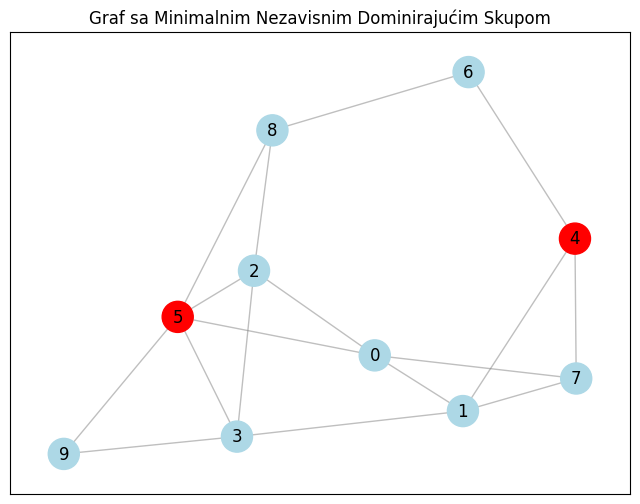

Processed graph test_10_0.3.in and saved results.


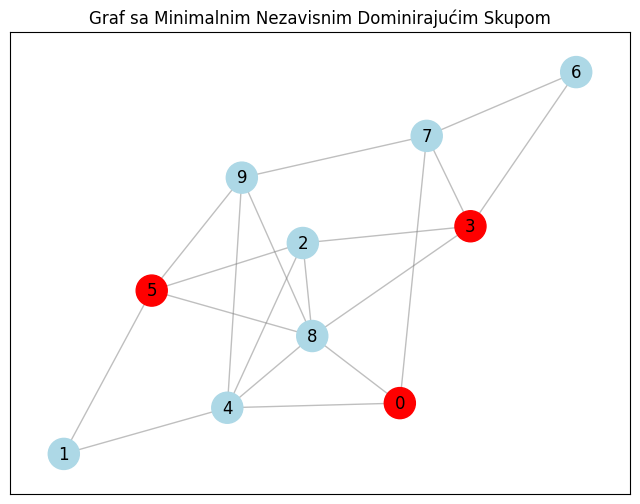

Processed graph test_10_0.5.in and saved results.


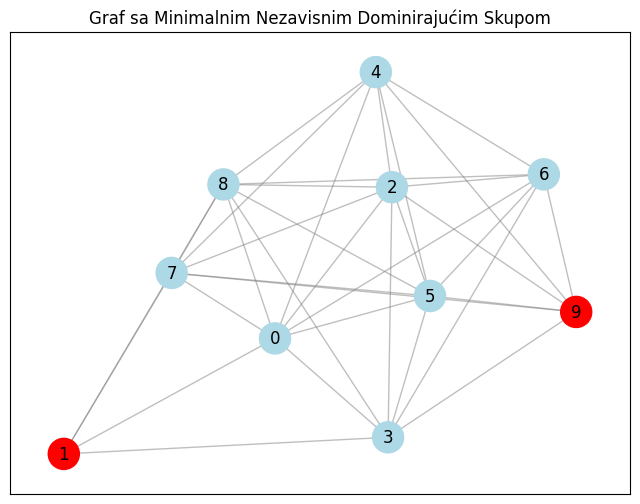

Processed graph test_10_0.7.in and saved results.


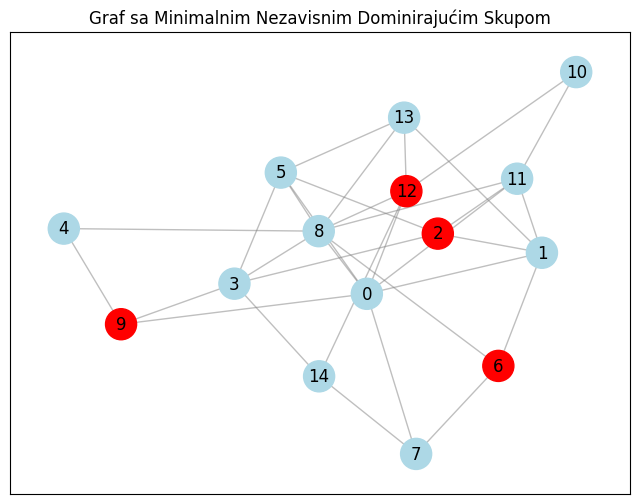

Processed graph test_15_0.3.in and saved results.


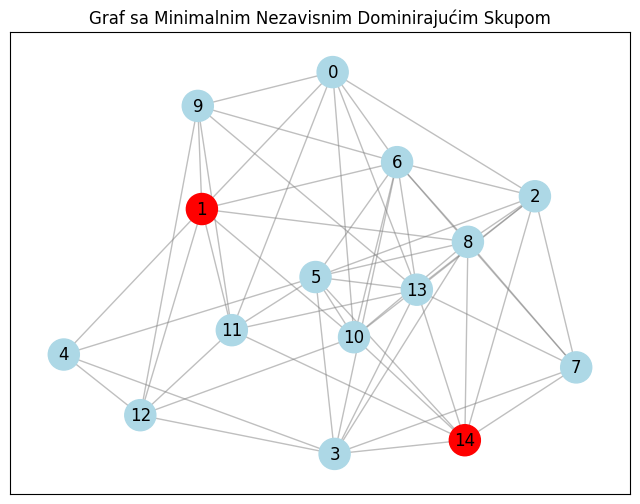

Processed graph test_15_0.5.in and saved results.


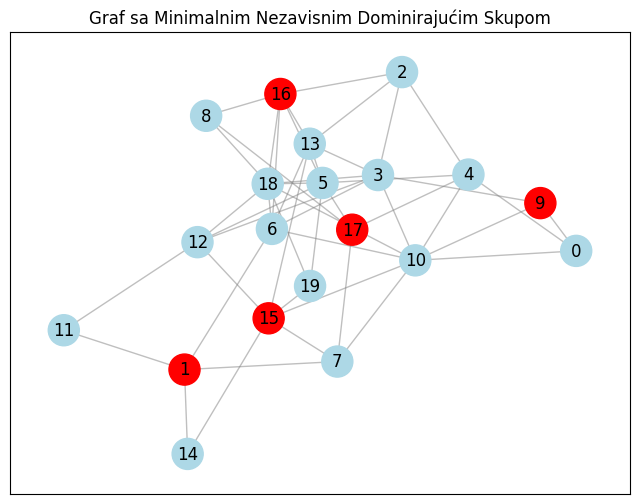

Processed graph test_20_0.3.in and saved results.


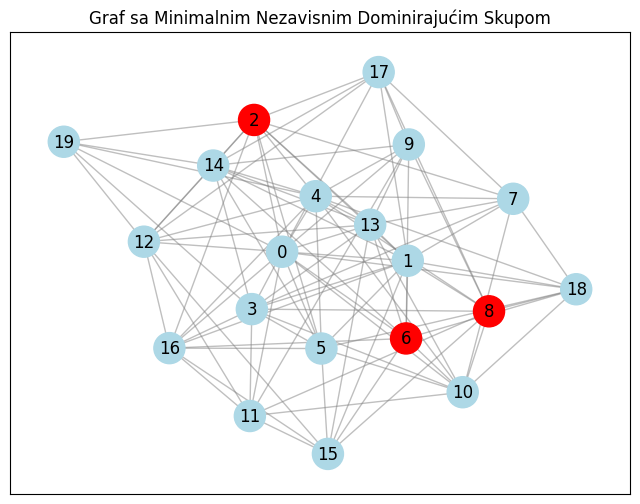

Processed graph test_20_0.5.in and saved results.


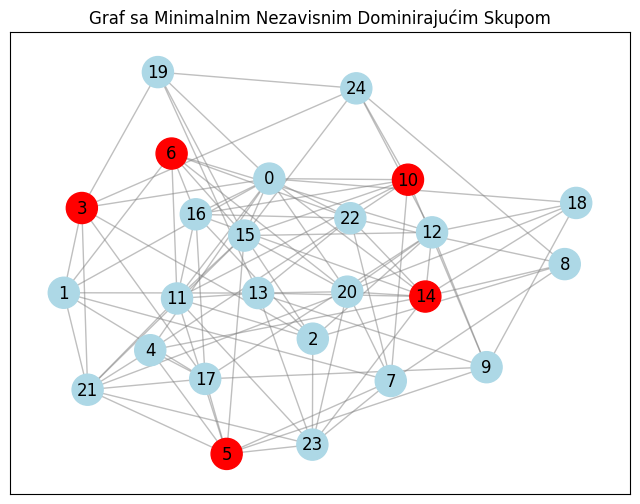

Processed graph test_25_0.3.in and saved results.


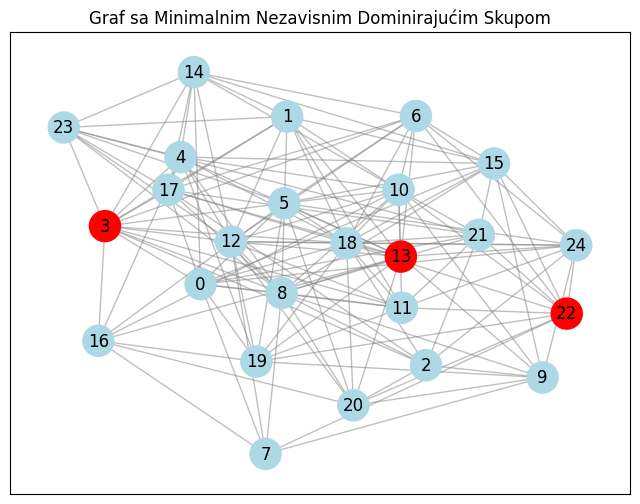

Processed graph test_25_0.5.in and saved results.


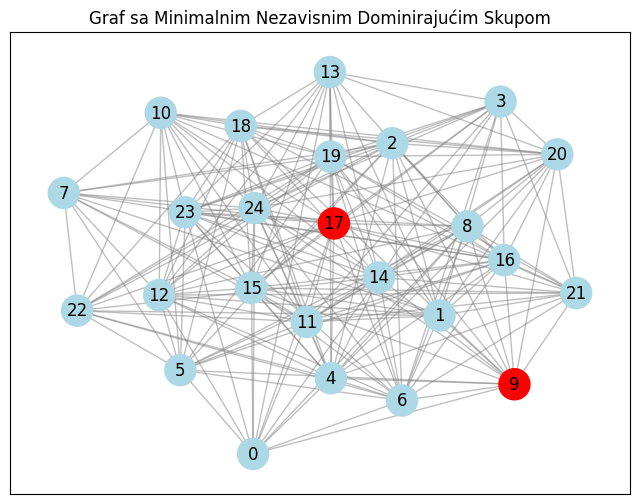

Processed graph test_25_0.7.in and saved results.


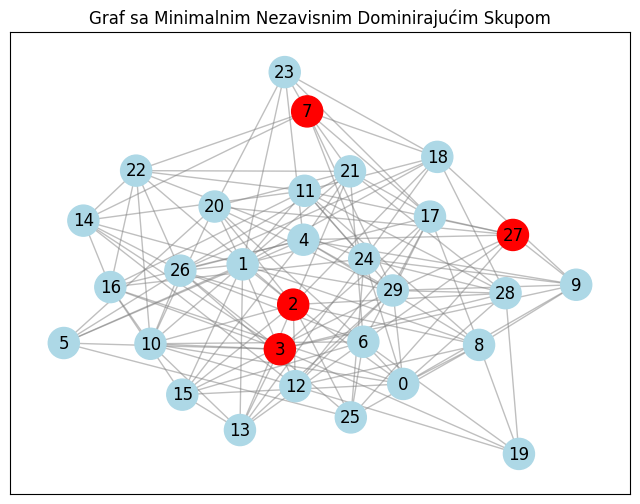

Processed graph test_30_0.3.in and saved results.


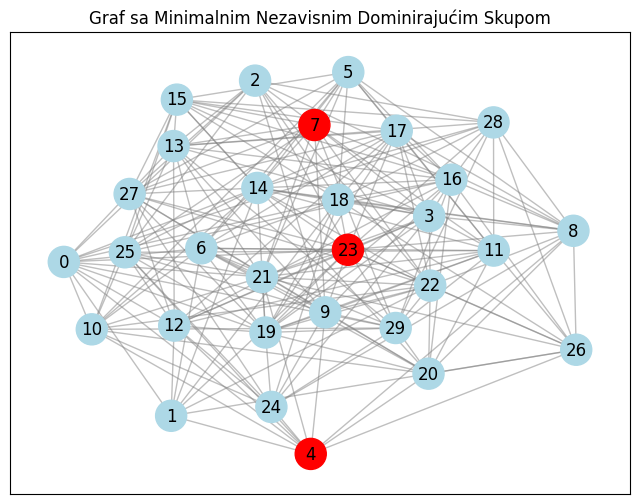

Processed graph test_30_0.5.in and saved results.


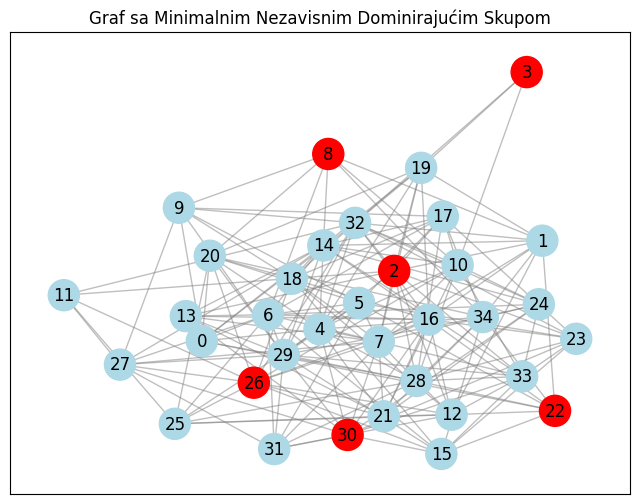

Processed graph test_35_0.3.in and saved results.


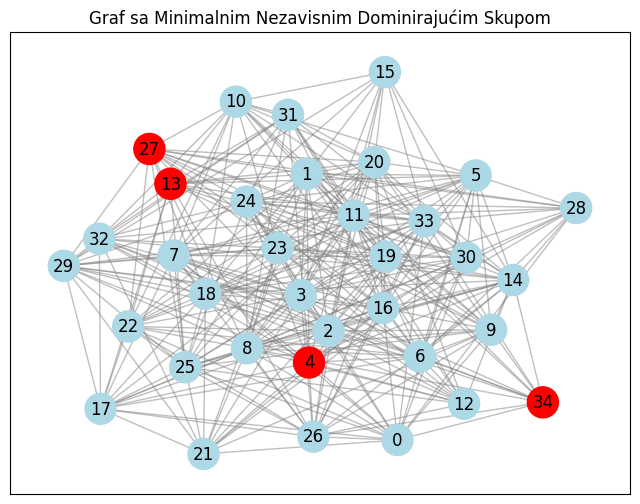

Processed graph test_35_0.5.in and saved results.


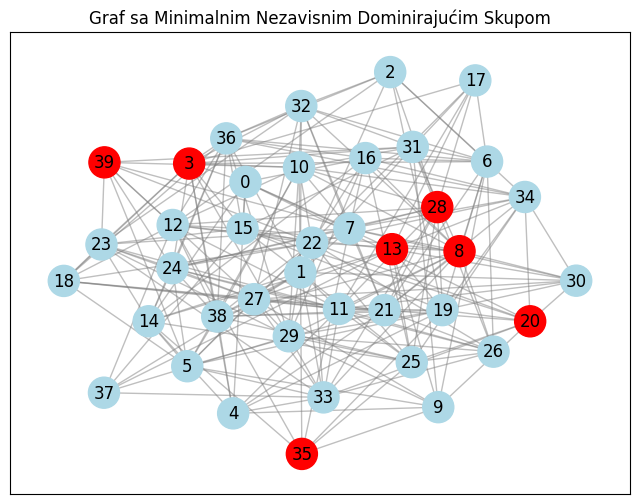

Processed graph test_40_0.3.in and saved results.


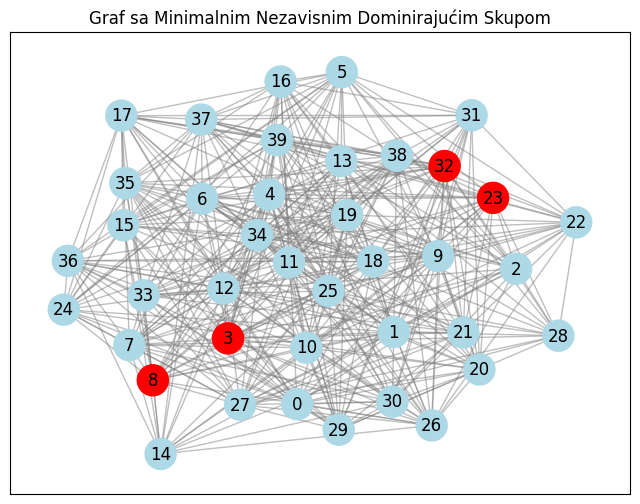

Processed graph test_40_0.5.in and saved results.


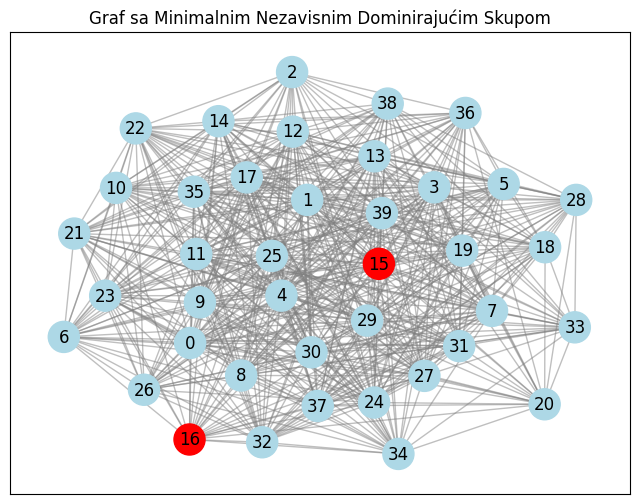

Processed graph test_40_0.7.in and saved results.


In [20]:
def run_ga_on_tests(directory="tests/", results_dir="results/", output_file="gaResults.txt"):
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)

    output_path = os.path.join(results_dir, output_file)
    
    with open(output_path, 'w') as f_out:
        for filename in os.listdir(directory):
            if filename.endswith(".in"):  
                graph_path = os.path.join(directory, filename)
                
                graph = nx.read_gml(graph_path)
                
                start_time = time.time()
                
                best_code, best_fitness = ga_main(graph)
                
                elapsed_time = time.time() - start_time
                
                num_nodes_in_set = len([i for i, included in enumerate(best_code) if included])
                num_iterations = 10000  
                result_message = "Minimum independent dominating set found." if best_fitness != float('-inf') else "No valid solution found."
                
                f_out.write(f"Test Name: {filename}\n")
                f_out.write(f"Result: {result_message}\n")
                f_out.write(f"Fitness value: {best_fitness}\n")
                f_out.write(f"Number of iterations: {num_iterations}\n")
                f_out.write(f"Time taken (seconds): {elapsed_time}\n")
                f_out.write("\n") 

                draw_graph(graph, best_code)

                print(f"Processed graph {filename} and saved results.")

run_ga_on_tests(directory="tests/", results_dir="results/", output_file="gaResults.txt")
